# Make crops, not war

In [2]:
import sys
sys.path.append("..")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib
from src.plots import country_in_war

%matplotlib inline

sns.set_style('whitegrid')

# add time converter for matplotlib visualisation
pd.plotting.register_matplotlib_converters()

In [3]:
prep_data_path = '../pandas_dfs/'

merged_data_file = 'merged_data.csv'
wars_file = 'final_wars_df.csv'
years_per_country_file = 'years_per_country.csv'

merged_crops_data = pd.read_csv(prep_data_path + merged_data_file)
wars_df = pd.read_csv(prep_data_path + wars_file)
years_per_country = pd.read_csv(prep_data_path + years_per_country_file)

First, let us change some names which are different among the dataframes:

In [4]:
merged_crops_data.loc[merged_crops_data['country'] == 'Viet Nam', 'country'] = 'Vietnam'
merged_crops_data.loc[merged_crops_data['country'].str.contains('Syria'), 'country'] = 'Syria'
merged_crops_data.loc[merged_crops_data['country'] == 'Sudan (former)', 'country'] = 'Sudan'
merged_crops_data.loc[merged_crops_data['country'] == 'Russian Federation', 'country'] = 'Russia'
merged_crops_data.loc[merged_crops_data['country'] == 'USSR', 'country'] = 'Soviet Union'
merged_crops_data.loc[merged_crops_data['country'] == "Lao People's Democratic Republic", 'country'] = 'Laos'

In [5]:
merged_crops_data.corr()

,value_crop,value_livestock,value_population,value_land_area
value_crop,1.000000,0.777054,0.889221,0.762014
value_livestock,0.777054,1.000000,0.874261,0.791917
value_population,0.889221,0.874261,1.000000,0.689464
value_land_area,0.762014,0.791917,0.689464,1.000000


Even though there is no correlation at the country level, among production and population and land area, there is still a quite strong general one. Thus we can try to normalize production according to population and land area. 

In [6]:
norm_factor = merged_crops_data['value_population'] * merged_crops_data['value_land_area']
merged_crops_data['norm_value_crop'] = merged_crops_data['value_crop'] / norm_factor
merged_crops_data['norm_value_livestock'] = merged_crops_data['value_livestock'] / norm_factor

avg_production_per_country = (
    merged_crops_data
        .groupby('country')
        .mean()
        .drop(['value_crop', 'value_livestock', 'value_population', 'value_land_area'], axis=1)
        .reset_index()
)

avg_production_per_country

,country,norm_value_crop,norm_value_livestock
0,Afghanistan,0.011558,0.041100
1,Albania,0.581650,1.017409
2,Algeria,0.009232,0.018848
3,American Samoa,60.165591,1.652843
4,Angola,0.009132,0.007849
...,...,...,...
215,Western Sahara,0.003364,0.196400
216,Yemen,0.010243,0.038251
217,Yugoslav SFR,0.106129,0.045730
218,Zambia,0.023572,0.019827


In [7]:
avg_production_years_in_war = (
    avg_production_per_country
        .merge(years_per_country, on='country', how='left')
        .dropna()
)


In [8]:
avg_production_years_in_war.head()

,country,norm_value_crop,norm_value_livestock,years
0,Afghanistan,0.011558,0.041100,28.0
2,Algeria,0.009232,0.018848,27.0
4,Angola,0.009132,0.007849,57.0
7,Armenia,0.486339,0.268927,7.0
10,Azerbaijan,0.130057,0.225317,7.0


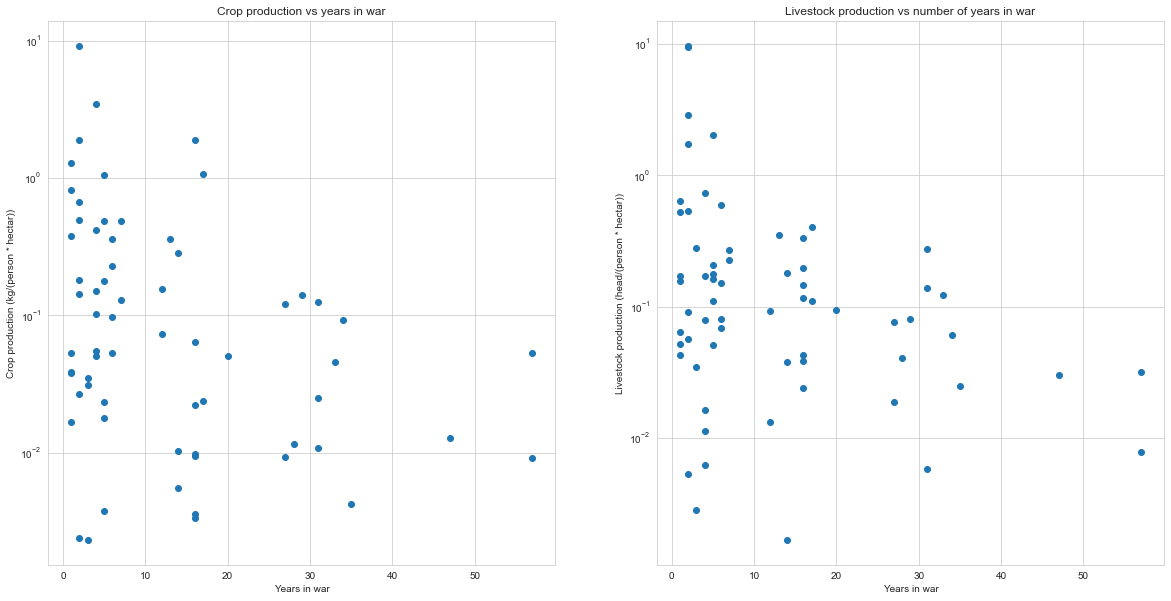

In [9]:
years_in_war = avg_production_years_in_war['years']
mean_crops = avg_production_years_in_war['norm_value_crop']
mean_livestock = avg_production_years_in_war['norm_value_livestock']

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(years_in_war, mean_crops, marker='o', linestyle='None')
ax[0].set_title('Crop production vs years in war')
ax[0].set_ylabel('Crop production (kg/(person * hectar))')
ax[0].set_xlabel('Years in war')
ax[0].set_yscale('log')

# for i, txt in enumerate(avg_production_years_in_war['country']):
#    ax[0].annotate(txt, (years_in_war[i], mean_crops[i]))

ax[1].plot(years_in_war, mean_livestock, marker='o', linestyle='None')
ax[1].set_title('Livestock production vs number of years in war')
ax[1].set_ylabel('Livestock production (head/(person * hectar))')
ax[1].set_xlabel('Years in war')
_ = ax[1].set_yscale('log')

In [82]:
afghanistan_crops = (
    merged_crops_data[merged_crops_data['country'] == 'Afghanistan']
        .drop(['norm_value_crop', 'norm_value_livestock', 'value_population', 'value_land_area', 'value_livestock'], axis=1)
)

afghanistan_in_war = country_in_war(wars_df, afghanistan_crops, 'Afghanistan')

first_row = pd.DataFrame({'in_war': False, 'value_crop': 0, 'year': np.NaN}, index=[0])

afghanistan_shifted = (
    pd.concat([first_row, afghanistan_in_war[:]], sort=False).reset_index(drop=True)
        .drop(['year'], axis=1)[:-1]
        .rename(columns={'value_crop': 'previous_crop'})
)

rated_crops = pd.concat([afghanistan_shifted, afghanistan_crops], axis=1)[1:].reset_index(drop=True)

rated_crops['rate'] = rated_crops.apply(lambda row: row['value_crop'] - row['previous_crop'], axis=1)

grouped_rated_crops = rated_crops.groupby('in_war').mean().reset_index()

rate_in_war = grouped_rated_crops.loc[grouped_rated_crops['in_war'] == True, 'rate'].to_numpy()
rate_not_in_war = grouped_rated_crops.loc[grouped_rated_crops['in_war'] == False, 'rate'].to_numpy()

rate_in_war[0], rate_not_in_war[0]

(82827.92592592593, 36337.275862068964)

In [84]:
def compute_rate(wars_df, country, agricultural_data):
    
    country_crops = (
        agricultural_data[agricultural_data['country'] == country]
            .drop(['norm_value_crop', 'norm_value_livestock', 'value_population', 'value_land_area', 'value_livestock'], axis=1)
    )

    years_in_war = country_in_war(wars_df, country_crops, country)

    first_row = pd.DataFrame({'in_war': False, 'value_crop': 0, 'year': np.NaN}, index=[0])

    country_shifted = (
        pd.concat([first_row, years_in_war[:]], sort=False).reset_index(drop=True)
            .drop(['year'], axis=1)[:-1]
            .rename(columns={'value_crop': 'previous_crop'})
    )

    rated_crops = pd.concat([country_shifted, country_crops], axis=1)[1:].reset_index(drop=True)

    rated_crops['rate'] = rated_crops.apply(lambda row: row['value_crop'] - row['previous_crop'], axis=1)

    grouped_rated_crops = rated_crops.groupby('in_war').mean().reset_index()

    rate_in_war = grouped_rated_crops.loc[grouped_rated_crops['in_war'] == True, 'rate'].to_numpy()
    rate_not_in_war = grouped_rated_crops.loc[grouped_rated_crops['in_war'] == False, 'rate'].to_numpy()

    return rate_in_war[0], rate_not_in_war[0]
    
compute_rate(wars_df, 'Afghanistan', merged_crops_data)

(82827.92592592593, 36337.275862068964)

In [ ]:
912